## Project 5: Face Generation
##### Lekhraj Sharma, Udacity's Nanodegree Deep Learning Foundation, May 2017

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

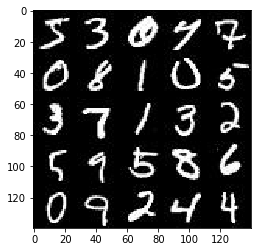

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

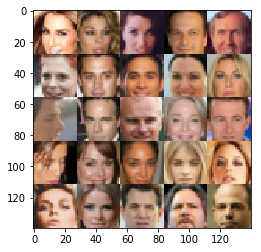

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_lr = tf.placeholder(tf.float32, name='input_lr')
    
    return inputs_real, inputs_z, inputs_lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def LeakyReLU(h, alpha):
    return tf.maximum(alpha * h, h)

def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1: Input layer is 28x28x3 or 28x28x1
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        h1 = LeakyReLU(h1, alpha)

        # Layer 2: Input is 14x14x128
        h2 = tf.layers.conv2d(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)                 
        h2 = LeakyReLU(h2, alpha)
                        
        # Final Layer: Input is 7x7x256
        h2_flat = tf.reshape(h2, (-1, 7*7*256))
        logits = tf.layers.dense(h2_flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected Hidden layer: output 7x7x256
        x1 = tf.layers.dense(z, 7*7*256, use_bias=False, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)         
        x1 = LeakyReLU(x1, alpha)

        # First conv Hidden layer: output 14x14x128
        h1 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        h1 = tf.layers.batch_normalization(h1, training=is_train)         
        h1 = LeakyReLU(h1, alpha)

        # Output layer: output 28x28xout_channel_dim
        logits =tf.layers.conv2d_transpose(h1, out_channel_dim, 5, strides=2, padding='same')       
        out = tf.tanh(logits)
        
        return out    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :return: losses (discriminator and generator)
    """
    # TODO: Build Model
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.25)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale the input image (-0.5 to 0.5) to -1 to 1 range
                batch_images = batch_images * 2 

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                    
    return losses      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 1.5821
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 1.7309
Epoch 1/2... Discriminator Loss: 1.8309... Generator Loss: 0.2235
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.4837


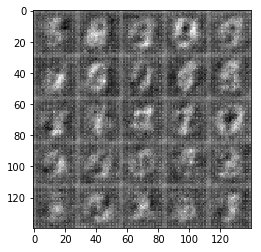

Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 1.7048
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 2.2999
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 2.1044
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.8658
Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 1.6644
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 2.0264
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.6665


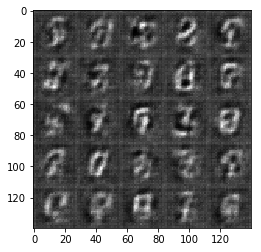

Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.3928
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.6195
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.5180
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.6405
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.7528
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.6911


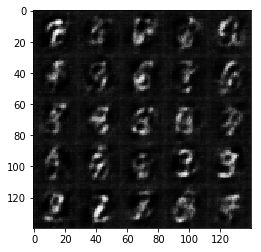

Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.7147
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 1.5561
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.7404
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 0.6764


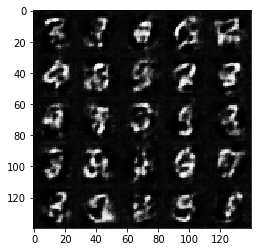

Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.5147
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.9607
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.7105
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.6919
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.2064
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.7217
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.5620


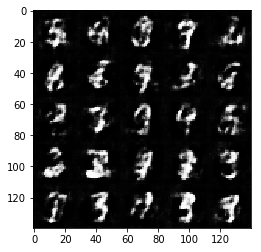

Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.4915
Epoch 2/2... Discriminator Loss: 0.7500... Generator Loss: 1.6503
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.3850
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.7251
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.1455


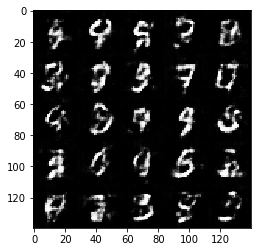

Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 0.5795... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.7967
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.4620


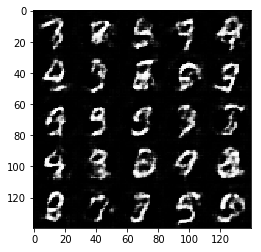

Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 1.8726
Epoch 2/2... Discriminator Loss: 0.6384... Generator Loss: 1.5863
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.7531
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.1217
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.4684
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.4557
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.4798
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.0205
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.1099


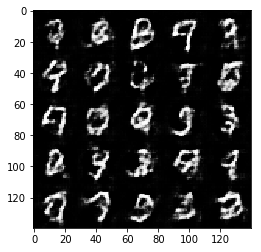

Epoch 2/2... Discriminator Loss: 0.6429... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 1.8100
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.1575
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 2.1888
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.0993
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 1.9379
Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.4990
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.6070
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 0.9160


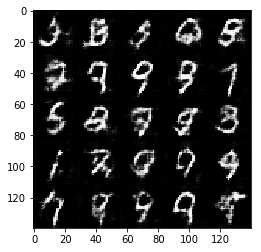

Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.5143
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.7958


In [13]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2 

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 1.8710
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.3499
Epoch 1/1... Discriminator Loss: 0.1974... Generator Loss: 2.4018
Epoch 1/1... Discriminator Loss: 0.1260... Generator Loss: 3.0043
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.5112
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 3.3919
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 3.3311
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.3468


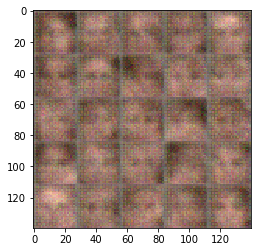

Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 1.7420
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.2899
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.4241
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.4762


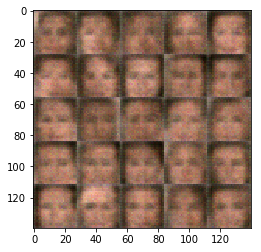

Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.6449


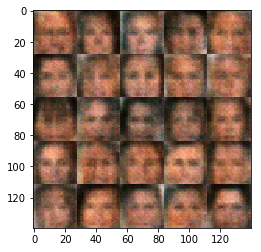

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 2.2328
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.4820
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.4899


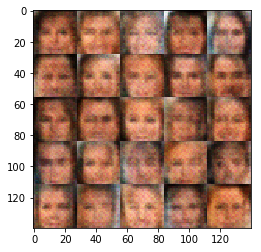

Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.6502
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.7169


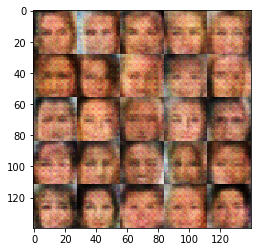

Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.6224


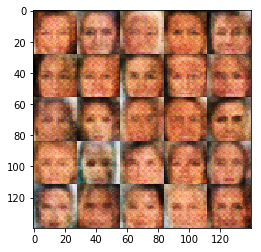

Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 2.8100... Generator Loss: 3.9490
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.6097


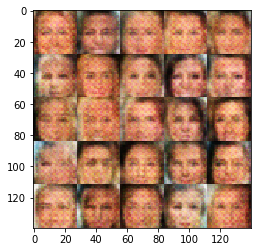

Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.7783


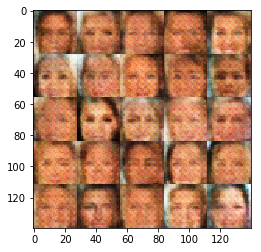

Epoch 1/1... Discriminator Loss: 4.5910... Generator Loss: 0.0327
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 2.4328... Generator Loss: 0.1646


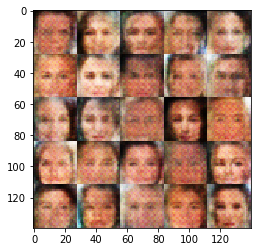

Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.2113


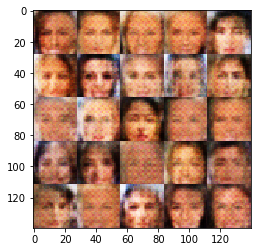

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.7390... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.1549


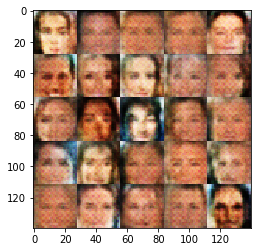

Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 2.0302
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.7053
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 2.1864


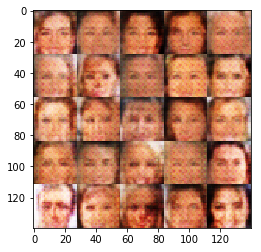

Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 2.2824
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.6540
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.7286
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 2.4376
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.5399
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 2.4200


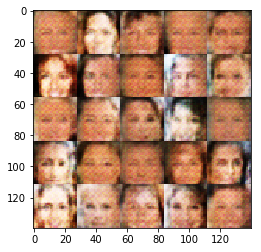

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 2.0659
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 2.3896
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 2.0143
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.6255
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.9078


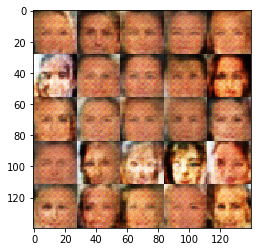

Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 2.0178
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 2.0445
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 2.6524
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.8912
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.6260


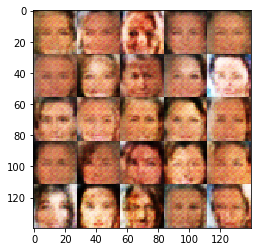

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 2.1960
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 2.1984
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 2.2883
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.9954
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 2.3100
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 3.1472


In [15]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.